Image folder: c:\Users\mirela\Documents\gitRepos\CatWatcher\cats_approach_training_2024_05_19/all
Epoch 1/100
400/400 [==============================] - 8s 6ms/step - loss: 0.7354 - accuracy: 0.6689 - val_loss: 0.9251 - val_accuracy: 0.6843 - lr: 1.0000e-04
Epoch 2/100
400/400 [==============================] - 2s 5ms/step - loss: 0.5944 - accuracy: 0.7131 - val_loss: 0.6507 - val_accuracy: 0.6933 - lr: 1.0000e-04
Epoch 3/100
400/400 [==============================] - 2s 5ms/step - loss: 0.5377 - accuracy: 0.7403 - val_loss: 0.6280 - val_accuracy: 0.7038 - lr: 1.0000e-04
Epoch 4/100
400/400 [==============================] - 2s 5ms/step - loss: 0.5066 - accuracy: 0.7522 - val_loss: 0.5431 - val_accuracy: 0.7285 - lr: 1.0000e-04
Epoch 5/100
400/400 [==============================] - 2s 5ms/step - loss: 0.4670 - accuracy: 0.7670 - val_loss: 0.5430 - val_accuracy: 0.7433 - lr: 1.0000e-04
Epoch 6/100
400/400 [==============================] - 2s 4ms/step - loss: 0.4399 - accuracy: 0.7806 -

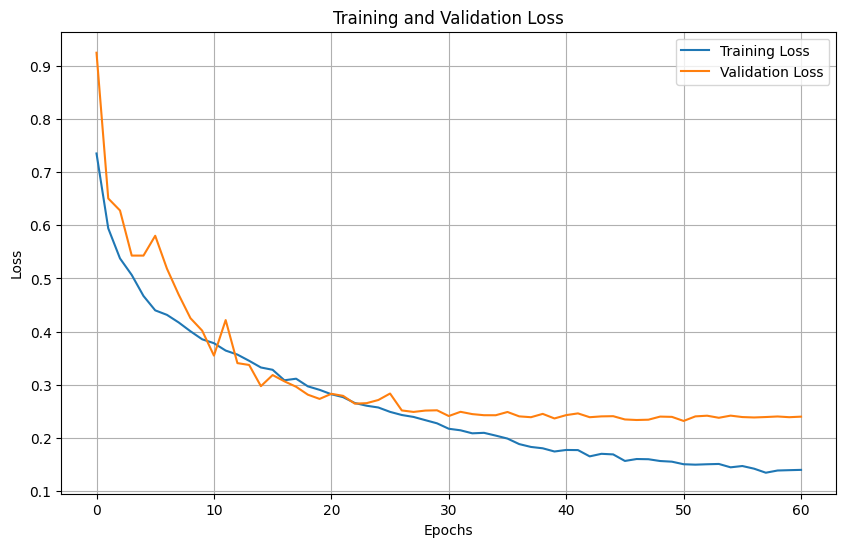

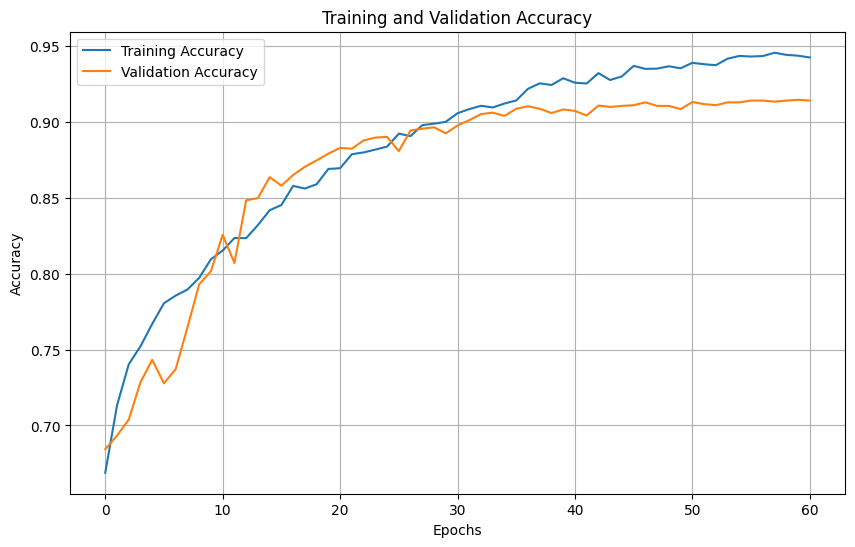

134/134 [==============================] - 0s 1ms/step - loss: 0.1917 - accuracy: 0.9242
Test Loss: 0.19170726835727692
Test Accuracy: 0.924196183681488
134/134 [==============================] - 0s 1ms/step
                 precision    recall  f1-score   support

No Cat approach       0.94      0.94      0.94      2880
   Cat approach       0.88      0.88      0.88      1381

       accuracy                           0.92      4261
      macro avg       0.91      0.91      0.91      4261
   weighted avg       0.92      0.92      0.92      4261



In [2]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf

# Define the path to the "cats_training" folder
image_folder = os.path.join(os.getcwd(), 'cats_approach_training_2024_05_19/all')
print("Image folder:", image_folder)

# Check for GPU availability
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Preprocess images
def preprocess_image(file_name):
    img_path = os.path.join(image_folder, file_name)
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Unable to read the image file {img_path}. Check file path and integrity.")
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    return img

# Load and preprocess data
df = pd.read_csv('labels2.csv')
df.columns = ['img', 'approach']
#df = df[df['approach'] != 'x']
#df['approach'] = df['approach'].apply(lambda x: 'y' if x == 'p' else x)
df['img'] = df['img'].apply(preprocess_image)
df['approach'] = df['approach'].apply(lambda x: 1 if x == 'y' else 0)

# Split data into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert dataframes to numpy arrays
X_train = np.array(list(train_df['img']))
y_train = np.array(list(train_df['approach']))
X_val = np.array(list(val_df['img']))
y_val = np.array(list(val_df['approach']))
X_test = np.array(list(test_df['img']))
y_test = np.array(list(test_df['approach']))

# Create the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('models/best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Plot training & validation loss and accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions on the test set
predictions = model.predict(X_test)
predictions = np.round(predictions).astype(int).flatten()

# Generate a classification report
report = classification_report(y_test, predictions, target_names=['No Cat approach', 'Cat approach'])
print(report)



In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       2

In [6]:
len(model.layers)

20

In [7]:
model.layers